### Load Dataset

In [11]:
import pandas as pd

df = pd.read_csv('./data/dataset.csv')

### Model 1: Use KMeans to cluster the data

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Convert 'food' to a single string per row 
df['food'] = df['food'].apply(lambda x: ' '.join(str(x).split()))

# Vectorize the 'food' column
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['food'])

# Clustering with KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

# The labels_ attribute contains the cluster assignments for each food item
df['food_cluster'] = kmeans.labels_


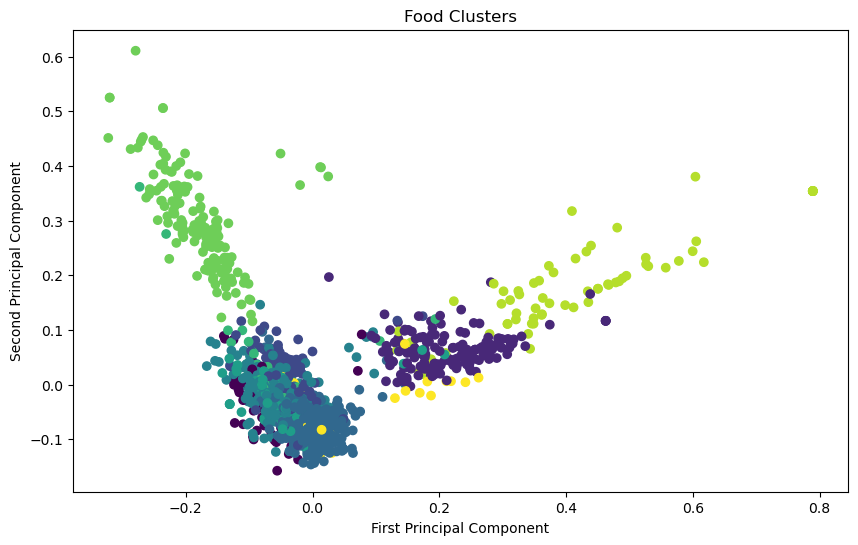

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['food_cluster'], cmap='viridis')
plt.title('Food Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


##### Using "Food Title" as the input feature

In [14]:
import pandas as pd

def recommend_food(df, food_item, num_recommendations=5):
    # Find the cluster of the given food item
    food_item_cluster = df[df['food'] == food_item]['food_cluster'].values[0]
    
    # Find all food items in the same cluster
    similar_food_items = df[df['food_cluster'] == food_item_cluster]
    
    # Exclude the given food item from the recommendations
    similar_food_items = similar_food_items[similar_food_items['food'] != food_item]
    
    # Select a random sample of similar food items
    recommendations = similar_food_items.sample(n=num_recommendations)
    
    return recommendations


In [15]:
recommendations = recommend_food(df, 'Pizza')
print(recommendations[['food', 'food_cluster']])


                                    food  food_cluster
829   Pilsner Urquell And Spicy Linguini             3
1915       Curried Broccoli Cheddar Soup             3
1477        Easy Link &amp; Veggie Pizza             3
612                        Bouillabaisse             3
1305                          Fried Okra             3


##### Using Values such as "Food Type", "Allergy", "Calories", "Fat", "Protein", "Carbohydrates" as the output feature

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_input(food_type, calories, fat_content, protein_content, gluten_free, dairy_free):
    # Convert boolean values to strings for consistency
    gluten_free = 'True' if gluten_free else 'False'
    dairy_free = 'True' if dairy_free else 'False'
    
    # Combine all criteria into a single string
    input_string = f"{food_type} {calories} {fat_content} {protein_content} {gluten_free} {dairy_free}"
    
    return input_string


In [17]:
def find_cluster(input_string, vectorizer, kmeans):
    # Vectorize the input string
    input_vector = vectorizer.transform([input_string])
    
    # Predict the cluster of the input string
    cluster = kmeans.predict(input_vector)[0]
    
    return cluster


In [18]:
def recommend_food_by_cluster(df, cluster, num_recommendations=5):
    # Find all food items in the same cluster
    similar_food_items = df[df['food_cluster'] == cluster]
    
    # Select a random sample of similar food items
    recommendations = similar_food_items.sample(n=num_recommendations)
    
    return recommendations


In [19]:
def recommend_food_by_criteria(df, vectorizer, kmeans, food_type, calories, fat_content, protein_content, gluten_free, dairy_free, num_recommendations=5):
    # Preprocess the input criteria
    input_string = preprocess_input(food_type, calories, fat_content, protein_content, gluten_free, dairy_free)
    
    # Find the cluster of the input criteria
    cluster = find_cluster(input_string, vectorizer, kmeans)
    
    # Recommend food items from the same cluster
    recommendations = recommend_food_by_cluster(df, cluster, num_recommendations)
    
    return recommendations


In [21]:
recommendations = recommend_food_by_criteria(df, vectorizer, kmeans, 'Veg', 500, 20, 30, True, True)
print(recommendations[['food', 'food_type', 'Calories', 'FatContent', 'ProteinContent', 'glutenFree', 'dairyFree']])


                                 food food_type  Calories  FatContent  \
1477     Easy Link &amp; Veggie Pizza       Veg     852.5        53.1   
706          Cajun Shrimp and Catfish   Non-Veg    1576.3        52.2   
1823        Snow Peas With Fresh Mint       Veg      69.0         4.7   
1736     Spicy Seasoned Pickled Beets       Veg     119.9         0.6   
1158  Cornflake Cauliflower Casserole       Veg     207.3        15.7   

      ProteinContent  glutenFree  dairyFree  
1477            14.3       False      False  
706             26.0        True      False  
1823             2.4       False      False  
1736             3.0       False       True  
1158             9.3       False       True  


#### Check the accuracy of the model

In [24]:
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['food_cluster'], test_size=0.2, random_state=42)

from sklearn.cluster import KMeans

# Train a KMeans model on the training set
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X_train)


from sklearn.metrics import silhouette_score

# Predict the clusters for the test set
y_pred = kmeans.predict(X_test)

# Calculate the Silhouette Score
score = silhouette_score(X_test, y_pred)

print(f"Silhouette Score: {score}")




Silhouette Score: 0.014154696856477545


### Model 2: Use K Nearest Neighbors to cluster the data

In [24]:
import pandas as pd
df = pd.read_csv('./data/dataset.csv')

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
import re

#### Preprocess data and prepare the pipeline

In [26]:
# Function to preprocess the data
def encode_categorical_variables(dataframe):
    encoder = LabelEncoder()
    dataframe['food_type'] = encoder.fit_transform(dataframe['food_type'])
    return dataframe

def scaler_operation(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = encode_categorical_variables(dataframe)
    scaler = StandardScaler()
    data_prep = scaler.fit_transform(dataframe.iloc[:, 4:10].to_numpy())
    return data_prep, scaler

def nn_clustering(data_prep):
    nearest_neighbours = KNeighborsClassifier(metric='cosine', algorithm='brute')
    nearest_neighbours.fit(data_prep)
    return nearest_neighbours

def build_pipeline(nearest_neighbours, scaler, var):
    transformer = FunctionTransformer(nearest_neighbours.kneighbors, kw_args=var)
    model_pipeline = Pipeline([('std_scaler', scaler), ('NN', transformer)])
    return model_pipeline


In [27]:
def extract_data(dataframe, ingredients):
    extracted_data = dataframe.copy()
    extracted_data['food_type'] = extracted_data['food_type'].apply(lambda x: 1 if x == 'Non-Veg' else 0)
    for column in extracted_data.columns[4:10]:
        extracted_data[column] = pd.to_numeric(extracted_data[column], errors='coerce')
    extracted_data = extract_ingredient_filtered_data(extracted_data, ingredients)
    return extracted_data

def extract_ingredient_filtered_data(dataframe, ingredients):
    extracted_data = dataframe.copy()
    regex_string = ''.join(map(lambda x: f'(?=.*{x})', ingredients))
    extracted_data = extracted_data[extracted_data['ingredients'].str.contains(regex_string, regex=True, flags=re.IGNORECASE)]
    return extracted_data


In [28]:
def apply_pipeline(model_pipeline, _input, extracted_data):
    _input = np.array(_input).reshape(1, -1)
    return extracted_data.iloc[model_pipeline.transform(_input)[0]]


In [29]:
# Settting up the pipeline
data_prep, scaler = scaler_operation(df)
nearest_neighbours = nn_clustering(data_prep)
model_pipeline = build_pipeline(nearest_neighbours, scaler, {'n_neighbors': 5})

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_prep, df['food'], test_size=0.2, random_state=42)


In [30]:
def recommend_food_item(user_input):
    # Preprocess user input
    extracted_data = df.copy()
    
    # Define var dictionary with default value for n_neighbors
    var = {'n_neighbors': 5, 'return_distance': False}
    
    # Check if the extracted data has enough items to recommend
    if extracted_data.shape[0] >= var['n_neighbors']:
        data_prep, scaler = scaler_operation(extracted_data)
        nearest_neighbours = nn_clustering(data_prep)
        model_pipeline = build_pipeline(nearest_neighbours, scaler, var)
        
        # Prepare user input
        input_data = pd.DataFrame({
            'food_type': [1 if user_input['food_type'].lower() == 'non-veg' else 0],
            'glutenFree': 1 if user_input['glutenFree'] else 0,
            'dairyFree': 1 if user_input['dairyFree'] else 0,
            'Calories': [user_input['Calories']],
            'FatContent': [user_input['FatContent']],
            'ProteinContent': [user_input['ProteinContent']]
        })
        
        # Apply the pipeline to the input data
        recommended_indices = model_pipeline.transform(input_data)[0]
        recommended_items = extracted_data.iloc[recommended_indices]

        # Prepare response in the expected format
        response_data = [{'id': idx, 'food': food} for idx, food in zip(recommended_items['id'], recommended_items['food'])]
        return response_data


In [31]:
user_input = {
        'food_type': 'Non-Veg',
        'Calories': 500,
        'FatContent': 20,
        'ProteinContent': 30,
        'glutenFree': False,
        'dairyFree': True,    
    }
recommendations = recommend_food_item(user_input)    

/Users/devanshu/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [32]:
recommendations

[{'id': 1064, 'food': 'Paella'},
 {'id': 575, 'food': 'Roasted Cod And Scallions With Spiced Potatoes'},
 {'id': 436, 'food': 'Sautéed Bass with Shiitake Mushroom Sauce'},
 {'id': 403, 'food': 'Origami Sea Bass'},
 {'id': 529, 'food': 'Sea Bass with Marinated Vegetables'}]

#### Check the Accuracy of the Model

In [33]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_prep, df['food'], test_size=0.2, random_state=42)

# Fit the model on the training data
model_pipeline.fit(X_train)

# Predict the nearest neighbors for the test data
y_pred = model_pipeline.transform(X_test)

In [34]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(data_prep, df['food'])
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.486751572604568


### Model 3: Use Nearest Neighbors to cluster the data

In [17]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt


X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a k-Nearest Neighbors classifier
knn_classifier = NearestNeighbors(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.945
Precision: 0.9292929292929293
Recall: 0.9583333333333334


### Model 4: Use Neural Networks on the data

In [1]:
!pip show tensorflow-macos

Name: tensorflow-macos
Version: 2.9.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/devanshu/miniconda3/envs/tensorflow/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wrapt
Required-by: 


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [4]:
# Load the dataset
df = pd.read_csv('./data/dataset.csv')

In [5]:
df.columns

Index(['id', 'food', 'image', 'instructions', 'food_type', 'Calories',
       'FatContent', 'ProteinContent', 'glutenFree', 'dairyFree', 'sourceUrl',
       'ingredients'],
      dtype='object')

In [6]:
df = df.drop(columns=['id', 'sourceUrl', 'ingredients', 'image', 'instructions', 'sourceUrl'])

In [7]:
df.columns

Index(['food', 'food_type', 'Calories', 'FatContent', 'ProteinContent',
       'glutenFree', 'dairyFree'],
      dtype='object')

In [8]:
# Convert 'food_type' to binary
df['food_type'] = df['food_type'].map({'Non-Veg': 1, 'Veg': 0})

# Convert boolean values to integers
df['glutenFree'] = df['glutenFree'].astype(int)
df['dairyFree'] = df['dairyFree'].astype(int)
df['food_type'] = df['dairyFree'].astype(int)

#convert int64 to float64 for food_type, glutenFree, dairyFree
df['food_type'] = df['food_type'].astype('float64')
df['glutenFree'] = df['glutenFree'].astype('float64')
df['dairyFree'] = df['dairyFree'].astype('float64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   food            1941 non-null   object 
 1   food_type       1941 non-null   float64
 2   Calories        1941 non-null   float64
 3   FatContent      1941 non-null   float64
 4   ProteinContent  1941 non-null   float64
 5   glutenFree      1941 non-null   float64
 6   dairyFree       1941 non-null   float64
dtypes: float64(6), object(1)
memory usage: 106.3+ KB


In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Identify categorical columns
categorical_columns = ['food']

# Initialize LabelEncoder and OneHotEncoder
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()

# Encode categorical columns
for column in categorical_columns:
    if df[column].nunique() == 2: # Binary categorical variable
        df[column] = label_encoder.fit_transform(df[column])
    else: # Multi-class categorical variable
        # Apply OneHotEncoder and concatenate the result with the original DataFrame
        encoded_columns = one_hot_encoder.fit_transform(df[[column]]).toarray()
        encoded_df = pd.DataFrame(encoded_columns, columns=one_hot_encoder.get_feature_names_out([column]))
        df = pd.concat([df, encoded_df], axis=1)
        df.drop(columns=[column], inplace=True) # Drop the original categorical column

In [10]:
# Encode categorical variables
#df['food_type'] = LabelEncoder().fit_transform(df['food_type'])

# Split the data into features (X) and target (y)
X = df.drop('food_type', axis=1)
y = df['food_type']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [11]:
# Build a simple neural network model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


2024-04-02 05:22:04.539808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-02 05:22:04.540489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


2024-04-02 05:22:14.380896: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-02 05:22:14.596695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be

35/39 [=========================>....] - ETA: 0s - loss: 0.7886 - accuracy: 0.5009

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x25x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x25x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

39/39 [==============================] - 3s 24ms/step - loss: 0.7833 - accuracy: 0.5060 - val_loss: 0.7508 - val_accuracy: 0.5691
Epoch 2/10
 1/39 [..............................] - ETA: 0s - loss: 0.6430 - accuracy: 0.5938

2024-04-02 05:22:17.651079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc

39/39 [==============================] - 0s 9ms/step - loss: 0.4542 - accuracy: 0.8106 - val_loss: 0.7063 - val_accuracy: 0.5949
Epoch 3/10
39/39 [==============================] - 0s 9ms/step - loss: 0.2661 - accuracy: 0.9460 - val_loss: 0.6701 - val_accuracy: 0.6109
Epoch 4/10
39/39 [==============================] - 0s 9ms/step - loss: 0.1517 - accuracy: 0.9887 - val_loss: 0.6416 - val_accuracy: 0.6367
Epoch 5/10
39/39 [==============================] - 0s 9ms/step - loss: 0.0895 - accuracy: 0.9936 - val_loss: 0.6251 - val_accuracy: 0.6431
Epoch 6/10
39/39 [==============================] - 0s 9ms/step - loss: 0.0566 - accuracy: 0.9976 - val_loss: 0.6110 - val_accuracy: 0.6656
Epoch 7/10
39/39 [==============================] - 0s 9ms/step - loss: 0.0390 - accuracy: 0.9984 - val_loss: 0.5995 - val_accuracy: 0.6817
Epoch 8/10
39/39 [==============================] - 0s 9ms/step - loss: 0.0290 - accuracy: 0.9984 - val_loss: 0.5887 - val_accuracy: 0.6881
Epoch 9/10
39/39 [=============

In [13]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

13/13 [==============================] - 0s 29ms/step - loss: 0.5561 - accuracy: 0.7275
Test Loss: 0.5561382174491882, Test Accuracy: 0.7275063991546631


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x5x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x5x1x1xi1>'


### Model 5: Use SVM on the data

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [20]:
# Load the dataset
df = pd.read_csv('./data/dataset.csv')

# Drop unnecessary columns
df.drop(columns=['id', 'sourceUrl', 'ingredients', 'image', 'instructions'], inplace=True)

# Encode categorical variables
df['food_type'] = LabelEncoder().fit_transform(df['food_type'])
df['food'] = LabelEncoder().fit_transform(df['food'])

# Split the data into features (X) and target (y)
X = df.drop('food_type', axis=1)
y = df['food_type']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [21]:
# Train the SVM model
svm_model = SVC(C=1.0, kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [22]:
# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)


Accuracy: 0.6760925449871465
              precision    recall  f1-score   support

           0       0.80      0.58      0.67       221
           1       0.59      0.80      0.68       168

    accuracy                           0.68       389
   macro avg       0.69      0.69      0.68       389
weighted avg       0.71      0.68      0.68       389



### Conclusion

The K Means model is the best model for this dataset.